In [152]:
import pandas as pd
import numpy as np
import os
import datetime as dt

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

In [153]:
file_path = '{}/nem-data/nemde_clean/df_DUID_CO2_mean.pkl'.format(os.environ['HOME'])
df_mean = pd.read_pickle(file_path)
df_mean.head()

,Price,CO2E_EMISSIONS_FACTOR
2019-08-01 03:55:00,79.52391,0.380340
2019-08-01 03:50:00,79.17710,0.456409
2019-08-01 03:45:00,85.14416,0.573436
2019-08-01 03:40:00,84.78689,0.573436
2019-08-01 03:35:00,84.78346,0.573436


In [154]:
df_sub = df_mean[(df_mean.index > dt.datetime(2017,1,1))]
print(df_sub.index.min())
print(df_sub.index.max())
df_sub = df_sub.sort_index()
df_sub.head()

2017-01-01 00:05:00
2019-08-01 03:55:00


,Price,CO2E_EMISSIONS_FACTOR
2017-01-01 00:05:00,125.69000,0.473708
2017-01-01 00:10:00,216.49831,1.047576
2017-01-01 00:15:00,82.46039,1.093190
2017-01-01 00:20:00,79.99014,0.681150
2017-01-01 00:25:00,79.98988,0.708560


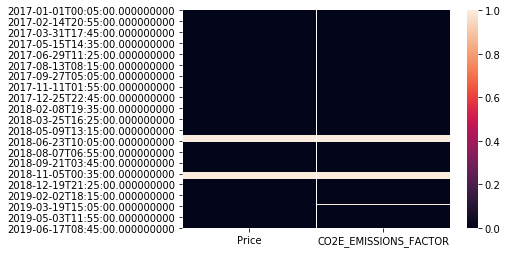

<Figure size 720x216 with 0 Axes>

In [155]:
fig = sns.heatmap(df_sub.isna())
plt.figure(figsize=(10,3));

In [158]:
from sklearn.impute import SimpleImputer


In [88]:
def time_columns(df):
    
    df.loc[:,"minute"] = df.index.minute
    df["hour"] = df.index.hour
    df["weekday"] = np.where(df.index.weekday < 5, 0, 1)
    df["month"] = df.index.month

    df['minute_sin'] = np.sin(2 * np.pi * df.loc[:,'minute']/60.0)
    df['minute_cos'] = np.cos(2 * np.pi * df.loc[:,'minute']/60.0)

    df['hour_sin'] = np.sin(2 * np.pi * df.loc[:,'hour']/24.0)
    df['hour_cos'] = np.cos(2 * np.pi * df.loc[:,'hour']/24.0)
    
    df['weekday_sin'] = np.sin(2 * np.pi * df.loc[:,'weekday']/7.0)
    df['weekday_cos'] = np.cos(2 * np.pi * df.loc[:,'weekday']/7.0)
    
    df['month_sin'] = np.sin(2 * np.pi * df.loc[:,'month']/12.0)
    df['month_cos'] = np.cos(2 * np.pi * df.loc[:,'month']/12.0)

    df.drop(columns=["Price", "minute", "weekday", "hour", "month"], inplace=True)
    
    return df

In [89]:
def lag_horizon(df, lag, horizon):
    '''
    The function generates a feature column representing subsets of the target (CO2) of size lag
    and associates it with a target column following the feature subset with gap = horizon
    df=df with column "CO2E_EMISSIONS_FACTOR"
    lag=integer
    horizon=integer
    '''
    lst_l = []
    lst_h = []
    
    [lst_l.append(list(k[i:i+lag])) for j,k in df.loc[:,["CO2E_EMISSIONS_FACTOR"]].iteritems() for i in range(df.shape[0]-lag)]
    [lst_l.append(np.nan) for i in range(df.shape[0]-lag,df.shape[0])]
    
    [lst_h.append(list(k[i+lag:i+lag+horizon])) for j,k in df.loc[:,["CO2E_EMISSIONS_FACTOR"]].iteritems() for i in range(df.shape[0]-(lag-1)-horizon)]
    [lst_h.append(np.nan) for i in range(df.shape[0]-(lag-1)-horizon,df.shape[0])]
    
    df["features"] = np.array(lst_l)
    df["features"] = df["features"].apply(lambda x: np.array(x))

    df["target"] = np.array(lst_h)
    df["target"] = df["target"].apply(lambda x: np.array(x))
        
    return df

In [145]:
df_sub = time_columns(df_sub)

In [146]:
df_sub.head()

,CO2E_EMISSIONS_FACTOR,minute_sin,minute_cos,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos
2017-01-01 00:05:00,0.473708,0.500000,8.660254e-01,0.0,1.0,0.781831,0.62349,0.5,0.866025
2017-01-01 00:10:00,1.047576,0.866025,5.000000e-01,0.0,1.0,0.781831,0.62349,0.5,0.866025
2017-01-01 00:15:00,1.093190,1.000000,2.832769e-16,0.0,1.0,0.781831,0.62349,0.5,0.866025
2017-01-01 00:20:00,0.681150,0.866025,-5.000000e-01,0.0,1.0,0.781831,0.62349,0.5,0.866025
2017-01-01 00:25:00,0.708560,0.500000,-8.660254e-01,0.0,1.0,0.781831,0.62349,0.5,0.866025


In [147]:
df_sub = lag_horizon(df_sub, lag = 7, horizon = 3)

In [148]:
df_sub.iloc[-14:]

,CO2E_EMISSIONS_FACTOR,minute_sin,minute_cos,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,features,target
2019-08-01 02:50:00,0.459168,-8.660254e-01,5.000000e-01,0.500000,0.866025,0.0,1.0,-0.866025,-0.5,"[0.4591678, 0.0, 0.45640854, 0.57343625, 0.573...","[0.0, 0.57343625, 0.57343625]"
2019-08-01 02:55:00,0.000000,-5.000000e-01,8.660254e-01,0.500000,0.866025,0.0,1.0,-0.866025,-0.5,"[0.0, 0.45640854, 0.57343625, 0.57343625, 0.57...","[0.57343625, 0.57343625, 0.57343625]"
2019-08-01 03:00:00,0.456409,0.000000e+00,1.000000e+00,0.707107,0.707107,0.0,1.0,-0.866025,-0.5,"[0.45640854, 0.57343625, 0.57343625, 0.5734362...","[0.57343625, 0.57343625, 0.57343625]"
2019-08-01 03:05:00,0.573436,5.000000e-01,8.660254e-01,0.707107,0.707107,0.0,1.0,-0.866025,-0.5,"[0.57343625, 0.57343625, 0.57343625, 0.5734362...","[0.57343625, 0.57343625, 0.45640854]"
2019-08-01 03:10:00,0.573436,8.660254e-01,5.000000e-01,0.707107,0.707107,0.0,1.0,-0.866025,-0.5,"[0.57343625, 0.57343625, 0.57343625, 0.0, 0.57...","[0.57343625, 0.45640854, 0.38034045]"
2019-08-01 03:15:00,0.573436,1.000000e+00,2.832769e-16,0.707107,0.707107,0.0,1.0,-0.866025,-0.5,"[0.57343625, 0.57343625, 0.0, 0.57343625, 0.57...",NaN
2019-08-01 03:20:00,0.573436,8.660254e-01,-5.000000e-01,0.707107,0.707107,0.0,1.0,-0.866025,-0.5,"[0.57343625, 0.0, 0.57343625, 0.57343625, 0.57...",NaN
2019-08-01 03:25:00,0.000000,5.000000e-01,-8.660254e-01,0.707107,0.707107,0.0,1.0,-0.866025,-0.5,NaN,NaN
2019-08-01 03:30:00,0.573436,5.665539e-16,-1.000000e+00,0.707107,0.707107,0.0,1.0,-0.866025,-0.5,NaN,NaN
2019-08-01 03:35:00,0.573436,-5.000000e-01,-8.660254e-01,0.707107,0.707107,0.0,1.0,-0.866025,-0.5,NaN,NaN


In [149]:
print(type(df_sub.iloc[-10:-9].target.values))
print(type(df_sub.iloc[-10:-9].features.values))
df_sub.iloc[-10:-9].features.values

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


array([array([0.57343625, 0.57343625, 0.57343625, 0.        , 0.57343625,
       0.57343625, 0.57343625])], dtype=object)

In [150]:
df_sub.isna().any()

CO2E_EMISSIONS_FACTOR    False
minute_sin               False
minute_cos               False
hour_sin                 False
hour_cos                 False
weekday_sin              False
weekday_cos              False
month_sin                False
month_cos                False
features                  True
target                    True
dtype: bool

In [151]:
df_sub[df_sub.index == dt.datetime(2018,6,15)]

,CO2E_EMISSIONS_FACTOR,minute_sin,minute_cos,hour_sin,hour_cos,weekday_sin,weekday_cos,month_sin,month_cos,features,target
2018-06-15,-1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.224647e-16,-1.0,"[-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0]","[-1.0, -1.0, -1.0]"


In [65]:
#from sklearn.model_selection import train_test_split

In [73]:
#X = df_sub.drop("target", axis=1)
#y= df_sub["target"]

In [74]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [125]:
def train_test_ts(df, relative_train, maximal_lag):
    '''
    Time series (ts) split function creates a train/test set under consideration of potential overlap between the two due to lag processing
    X_train, y_train, X_test, y_test = ...
    df=must contain target column as "target"; all other columns must be used as features
    percentage_train=how much of the total dataset shall be used for training; must be added between 0 - 1
    maximal_lag=out of all lag feature engineering, enter the maximal lag number
    '''
    k = int(df.shape[0] * relative_train)
    data_train = df.iloc[:k,:]
    #to avoid overlapping of train and test data, a gap of the maximal lag - 1 must be included between the two sets
    data_test = df.iloc[k+maximal_lag:,:]
    
    assert data_train.index.max() < data_test.index.min()
    
    #returns in the sequence X_train, y_train, X_test, y_test
    return data_train.drop("target", axis=1), data_train["target"], data_test.drop("target", axis=1), data_test["target"] #y_test

In [120]:
df = df_sub
relative_train = 0.8
maximal_lag = 7

k = int(df.shape[0] * relative_train)
data_train = df.iloc[:k,:]
#to avoid overlapping of train and test data, a gap of the maximal lag - 1 must be included between the two sets
data_test = df.iloc[k+maximal_lag:,:]

In [127]:
print(data_train.index.max())
print(data_test.index.min())
data_train.index.max() < data_test.index.min()

2019-01-24 17:30:00
2019-01-24 18:10:00


True

In [128]:
X_train, y_train, X_test, y_test = train_test_ts(df_sub, 0.8, 7)

In [129]:
c = int(df_sub.shape[0] * 0.8)
print(c)

print(X_train.shape)
print(X_train.index.min())
print(X_train.index.max())

print(y_train.shape)
print(y_train.index.min())
print(y_train.index.max())

217074
(217074, 10)
2017-01-01 00:05:00
2019-01-24 17:30:00
(217074,)
2017-01-01 00:05:00
2019-01-24 17:30:00


In [130]:
c = int(df_sub.shape[0] * (1-0.8))
print(c)

print(X_test.shape)
print(X_test.index.min())
print(X_test.index.max())

print(y_test.shape)
print(y_test.index.min())
print(y_test.index.max())

54268
(54262, 10)
2019-01-24 18:10:00
2019-08-01 03:55:00
(54262,)
2019-01-24 18:10:00
2019-08-01 03:55:00
